<a href="https://colab.research.google.com/github/JaimeRedondo/Mushrooms_Classification/blob/master/Mushrooms_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Import

In [3]:
#working with images
! pip install opencv-python
from matplotlib import image
from matplotlib import pyplot
from skimage import io
import cv2
import os
import skimage
from skimage import data, io, filters, transform

#--Web scraping packages
from bs4 import BeautifulSoup
import requests
import itertools
from urllib.request import Request, urlopen
import urllib.request

#Pandas/numpy for data manipulation
import pandas as pd
import numpy as np
from urllib.request import urlopen

#barrita de progreso
from tqdm.notebook import tqdm
from time import sleep 

#Visualize data
%pylab inline
plt.style.use('seaborn-talk')

#import deep learning libraries
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
import tensorflow as tf



Populating the interactive namespace from numpy and matplotlib


In [4]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Functions



Plotting function to see test and validation accuracy


In [5]:
#To plot test,train,and validation accuracy metrics.

def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  


#to see mushrooms when I want
def plot_mushroom_image(N, imgs, labels):
    print(labels[N])
    plt.imshow(imgs[N,], cmap=plt.cm.binary)
    plt.grid(True)

In [6]:
mushrooms_directory=[]
for folder in tqdm(os.listdir('/content/drive/MyDrive/Mushrooms_Classification')):
    if '.' in folder:
        pass
    else:
        mushrooms_directory.append(folder)
        
mushrooms_directory=sorted(mushrooms_directory)

In [7]:
mushrooms_directory

['Abortiporus biennis',
 'Adelphella babingtonii',
 'Agaricus arvensis',
 'Agaricus campestris',
 'Agaricus litoralis',
 'Agaricus sylvaticus',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus xanthodermus',
 'Agrocybe praecox']

In [10]:
#resize all images shape in 28x28 and print what photos are not available
def resize_photos(directory):
    
    for folder in tqdm(directory):
        for numero in range(20):
            try:
                route = '/content/drive/MyDrive/Mushrooms_Classification/'+folder +'/'+ str(numero) + '.jpg'
                data_picture = io.imread(route)
                data_picture = cv2.resize(data_picture, (200, 200))
                # save the images
                cv2.imwrite(route,data_picture)
            except:  
                print("imagen "+str(numero)+' de la seta '+folder+' no está disponible')

#standarize 0_255 pixels to 0 - 1.
lista=[]
def standarize_pixels_and_augmentation(directory):
    for folder in tqdm(directory):
        for numero in range(20):
            try:
                route ='/content/drive/MyDrive/Mushrooms_Classification/'+folder +'/'+ str(numero) + '.jpg'
                image_rgb=io.imread(route)/255.0

                ##DATA AUGMENTATION##

                flip_1 = np.fliplr(image_rgb)
                #mirror with vertical line on right


                rot_90 = tf.image.rot90(image_rgb, k=1)
                rot_180 = tf.image.rot90(image_rgb, k=2)
                rot_270 = tf.image.rot90(image_rgb, k=3)
                #rotation of 90, 180 and 270 grades

                #now we are going to crop the imgs, can be whatever siza of crop we want
                height, width = image_rgb.shape[0:2]

                startRow = int(height*.15)

                startCol = int(width*.15)

                endRow = int(height*.85)

                endCol = int(width*.85)

                croppedImage = image_rgb[startRow:endRow, startCol:endCol]

                croppedImage = cv2.resize(croppedImage, (200, 200))

                #now we are going to add contrast

                contrast_img = cv2.addWeighted(image_rgb, 1.5, np.zeros(image_rgb.shape, image_rgb.dtype), 0, 0)

                #desenfoque del 50% cogiendo la mediana de los pixeles
                #blur_image = cv2.medianBlur(img,1)

                #add to list

                lista.append(image_rgb)
                lista.append(flip_1)
                lista.append(rot_90)
                lista.append(rot_180)
                lista.append(rot_270)
                lista.append(croppedImage)
                lista.append(contrast_img)
                #lista.append(blur_image)

            except:
                print(folder+str(numero))                


def standarize_photos(directory):
    print("reshaping pictures...")
    resize_photos(directory)
    print("Normalizing pixels...")
    standarize_pixels_and_augmentation(directory)  

# Preparing data

In [11]:
standarize_photos(mushrooms_directory)

reshaping pictures...


imagen 4 de la seta Agaricus sylvaticus no está disponible

Normalizing pixels...


Agaricus sylvaticus4



In [12]:
len(lista)

1393

In [44]:
lista_categories=[]
for folder in tqdm(mushrooms_directory):
    for i in range(140):
        lista_categories.append(folder)
        
train_labels=np.array(lista_categories)

In [46]:
train_labels = list(train_labels)

In [57]:
train_labels.remove('Agaricus sylvaticus')

In [58]:
train_labels = np.array(train_labels)

In [59]:
len(train_labels)

1393

In [15]:
train_images = lista

In [16]:
len(train_images)

1393

In [37]:
test_labels=[]
for element in range(0,len(train_labels),140):
  test_labels.append(train_labels[element])
  test_labels.append(train_labels[element+7])

In [38]:
test_labels

['Abortiporus biennis',
 'Abortiporus biennis',
 'Adelphella babingtonii',
 'Adelphella babingtonii',
 'Agaricus arvensis',
 'Agaricus arvensis',
 'Agaricus campestris',
 'Agaricus campestris',
 'Agaricus litoralis',
 'Agaricus litoralis',
 'Agaricus sylvaticus',
 'Agaricus sylvaticus',
 'Agaricus sylvicola',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus urinascens',
 'Agaricus xanthodermus',
 'Agaricus xanthodermus',
 'Agrocybe praecox',
 'Agrocybe praecox']

In [39]:
test_images=[]
for element in range(0,len(train_images),140):
  test_images.append(train_images[element])
  test_images.append(train_images[element+7])


In [40]:
len(train_images)

1393

In [41]:
len(test_labels)

20

In [42]:
len(test_images)

20

In [60]:
lista_nueva_images=[]
for element in range(0,len(train_images),140):
  lista_partida = train_images[element:element+140]
  lista_partida = lista_partida[1:7]+lista_partida[8:]
  lista_nueva_images.append(lista_partida)

lista_nueva_images = [item for lista in lista_nueva_images for item in lista]

len(lista_nueva_images)

1373

In [61]:
len(train_labels)

1393

In [65]:
train_labels = list(train_labels)


In [66]:
lista_nueva_labels=[]
for element in range(0,len(train_labels),140):
  lista_partida = train_labels[element:element+140]
  lista_partida = lista_partida[1:7]+lista_partida[8:]
  lista_nueva_labels.append(lista_partida)

lista_nueva_labels = [item for lista in lista_nueva_labels for item in lista]

len(lista_nueva_labels)

1373

In [67]:
for i in range(len(lista_nueva_images)):

  if lista_nueva_images[i].shape != (200,200,3):
    print(lista_nueva_images[i].shape,i)

  #esto lo hago para que no haya problemas de fotos en blanco y negro únicamente

In [68]:
#transformamos otra vez a arrays los datos de train y de test

train_images, train_labels, test_images, test_labels = np.array(lista_nueva_images), np.array (lista_nueva_labels), np.array(test_images), np.array(test_labels)

In [69]:
test_images.shape

(20, 200, 200, 3)

Agaricus campestris


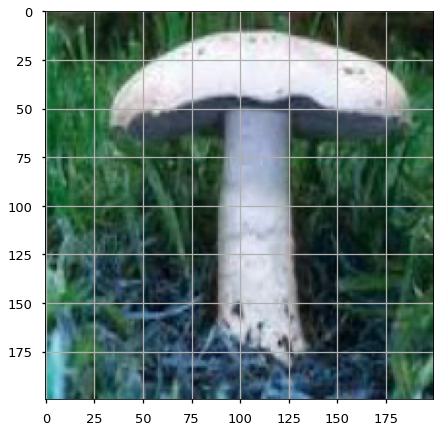

In [79]:
plot_mushroom_image(7,test_images,test_labels)

In [80]:
train_labels.shape
#cambiar formato nombres para que funcionen

(1373,)

In [81]:
np.unique(train_labels)

array(['Abortiporus biennis', 'Adelphella babingtonii',
       'Agaricus arvensis', 'Agaricus campestris', 'Agaricus litoralis',
       'Agaricus sylvaticus', 'Agaricus sylvicola', 'Agaricus urinascens',
       'Agaricus xanthodermus', 'Agrocybe praecox'], dtype='<U22')

In [82]:
l1 = list(range(10))
l2 = list(np.unique(train_labels))
d = dict(zip(l1,l2))
#create a dictionary to use one hot encoder

In [83]:
d

{0: 'Abortiporus biennis',
 1: 'Adelphella babingtonii',
 2: 'Agaricus arvensis',
 3: 'Agaricus campestris',
 4: 'Agaricus litoralis',
 5: 'Agaricus sylvaticus',
 6: 'Agaricus sylvicola',
 7: 'Agaricus urinascens',
 8: 'Agaricus xanthodermus',
 9: 'Agrocybe praecox'}

In [97]:
listote=range(0,3)

In [105]:
listonin = list(listote)

In [107]:
listonin.append(6)

In [109]:
listonin.remove(6)

In [110]:
listonin

[0, 1, 2]

In [84]:
train_labels_nums = sorted(list(d.keys())*138)

test_labels_nums = sorted(list(d.keys())*2)

In [117]:
train_labels_nums.remove(5)

In [118]:
len(train_labels_nums)

1373

In [119]:
len(test_labels_nums), len(train_labels_nums)

(20, 1373)

Transform to one hot encoder the 10 classes we hace for now

In [120]:
#transformamos a onehot nuestros targets 
onehot_train=to_categorical(train_labels_nums,num_classes=10)


onehot_test=to_categorical(test_labels_nums,num_classes=10)

onehot_train.shape,onehot_test.shape

((1373, 10), (20, 10))

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Applying CNN (Convolutional Neural Network)

Vamos a crear nuestra primera red neuronal convolucional

In [132]:
def build():  
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (200,200,3)))
  #model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 #activation ='relu'))
  #model.add(MaxPool2D(pool_size=(3,3)))
  #model.add(Dropout(0.5))


  #model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 #activation ='relu'))
  #model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 #activation ='relu'))
  #model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  #model.add(Dropout(0.5))


  model.add(Flatten())
  model.add(Dense(250, activation = "relu"))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation = "softmax"))

  model.summary()

  return model

In [133]:
model=build()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               320000250 
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
Total params: 320,003,656
Trainable params: 320,003,656
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.compile(optimizer=optimizers.Adam(),loss=losses.categorical_crossentropy,metrics=[metrics.categorical_accuracy])

In [135]:
train_images.shape

(1373, 200, 200, 3)

In [136]:
onehot_train.shape

(1373, 10)

y vamos con el modelo

In [137]:
 h = model.fit (train_images,onehot_train,batch_size= 40,epochs=30,validation_split=0.2)

Epoch 1/30
28/28 [==============================] - 4s 118ms/step - loss: 43.3001 - categorical_accuracy: 0.1716 - val_loss: 3.2358 - val_categorical_accuracy: 0.0000e+00
Epoch 2/30
28/28 [==============================] - 3s 108ms/step - loss: 1.9637 - categorical_accuracy: 0.2393 - val_loss: 8.0152 - val_categorical_accuracy: 0.0000e+00
Epoch 3/30
28/28 [==============================] - 3s 110ms/step - loss: 1.5029 - categorical_accuracy: 0.4533 - val_loss: 11.5279 - val_categorical_accuracy: 0.0000e+00
Epoch 4/30
28/28 [==============================] - 3s 110ms/step - loss: 1.1015 - categorical_accuracy: 0.6325 - val_loss: 15.2696 - val_categorical_accuracy: 0.0000e+00
Epoch 5/30
28/28 [==============================] - 3s 110ms/step - loss: 0.7931 - categorical_accuracy: 0.7320 - val_loss: 17.3699 - val_categorical_accuracy: 0.0000e+00
Epoch 6/30
28/28 [==============================] - 3s 109ms/step - loss: 0.5375 - categorical_accuracy: 0.8132 - val_loss: 22.4420 - val_categori

### Evaluating the model

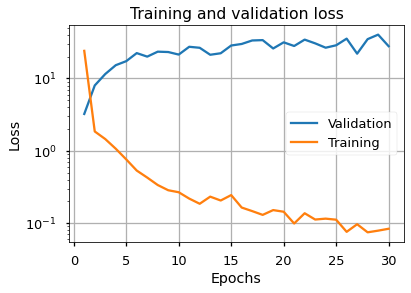

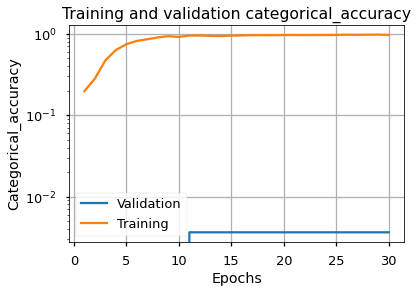

In [138]:
plot_metric(h,'loss')
plot_metric(h,'categorical_accuracy')

In [139]:
model.evaluate(test_images,onehot_test)

1/1 [==============================] - 0s 69ms/step - loss: 4.4187 - categorical_accuracy: 0.7500


[4.4187493324279785, 0.75]

### Doing predictions

In [140]:
y_pred = model.predict_classes(test_images)
y_pred

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7, 6, 7, 5, 5])

In [141]:
test_labels
target_names = pd.Series(test_labels).drop_duplicates()

In [142]:
d.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [143]:
predictions=[]
for i in y_pred:
  predictions.append(d.get(i))

In [144]:
predictions

['Abortiporus biennis',
 'Abortiporus biennis',
 'Adelphella babingtonii',
 'Adelphella babingtonii',
 'Agaricus arvensis',
 'Agaricus arvensis',
 'Agaricus arvensis',
 'Agaricus campestris',
 'Agaricus litoralis',
 'Agaricus litoralis',
 'Agaricus sylvaticus',
 'Agaricus sylvaticus',
 'Agaricus sylvicola',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus urinascens',
 'Agaricus sylvicola',
 'Agaricus urinascens',
 'Agaricus sylvaticus',
 'Agaricus sylvaticus']

In [162]:
test_labels

array(['Abortiporus biennis', 'Abortiporus biennis',
       'Adelphella babingtonii', 'Adelphella babingtonii',
       'Agaricus arvensis', 'Agaricus arvensis', 'Agaricus campestris',
       'Agaricus campestris', 'Agaricus litoralis', 'Agaricus litoralis',
       'Agaricus sylvaticus', 'Agaricus sylvaticus', 'Agaricus sylvicola',
       'Agaricus sylvicola', 'Agaricus urinascens', 'Agaricus urinascens',
       'Agaricus xanthodermus', 'Agaricus xanthodermus',
       'Agrocybe praecox', 'Agrocybe praecox'], dtype='<U22')

### Evaluating the test data

In [163]:
from sklearn.metrics import confusion_matrix


cm=confusion_matrix(test_labels, predictions, labels=target_names)

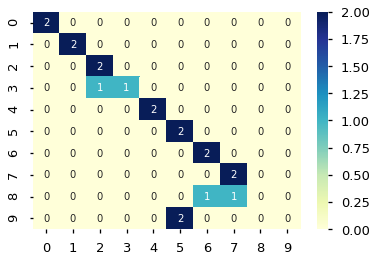

In [169]:
sns.heatmap(cm,annot=True,cmap="YlGnBu")